<a href="https://colab.research.google.com/github/GauravSingh-G/Autograd-Engine/blob/main/Neural_Network_Backpropagation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project: Autograd Engine & Neural Systems from Scratch
> **A hands-on implementation of core deep learning mechanics, demonstrating the transition from scalar calculus to a functional Multi-Layer Perceptron (MLP).**

---

### 🧩 Key Concepts & Skills Demonstrated

* **Automatic Differentiation (Autograd):** Built a custom `Value` class that handles the bookkeeping of a computational graph, mimicking the core logic of frameworks like PyTorch.
* **Computational Graph Visualization:** Integrated `graphviz` to visually audit the flow of data, operations, and gradients.
    
* **Neural Network Architecture:** Engineered modular `Neuron`, `Layer`, and `MLP` classes from fundamental building blocks.
    
* **Backpropagation & Gradient Descent:** Implemented the complete training loop—from `.backward()` logic using the Chain Rule to parameter updates (`p.data += -lr * p.grad`).
    
* **Validation & Reproducibility:** Confirmed mathematical accuracy by comparing gradients against `torch.autograd` and ensured consistent results using `random.seed()`.

---

In [383]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [384]:
#Derivative:
a=5
b=6
c=3
D=(a+b)*c

D
h=0.00000001
a+=h
d1=(a+b)*c
dD = (d1-D)/h

dD

3.000000248221113

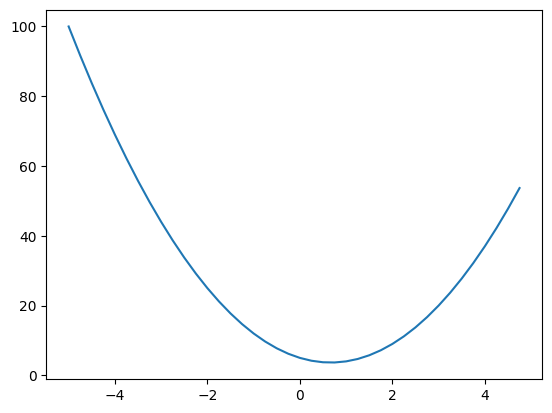

In [385]:
# Example: Plotting a quadratic function
def f(x):
    return 3*x**2 - 4*x + 5

xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [386]:
#Computational Graph Node with Automatic Differentiation
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other=other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward=_backward
        return out

    def __mul__(self, other):
        other=other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward=_backward
        return out

    def __rmul__(self, other): #other*self
        return self * other

    def __neg__(self):
        return self * -1

    def __sub__(self, other): #other*self
        return self + (-other)


    def __radd__(self, other):
        return self + other

    def __truediv__(self, other): #self / other
        return self * (other**-1)

    def __pow__(self, other):
      assert isinstance(other, (int, float)), "only supporting int/float powers for now"
      out = Value(self.data**other, (self,), f'**{other}')

      def _backward():
          self.grad += (other * (self.data ** (other - 1))) * out.grad
      out._backward = _backward

      return out;

    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward=_backward
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out

    def backward(self):
        topo=[]
        visited = set()
        def build_topo(v):
          if v not in visited:
            visited.add(v)
            for child in v._prev:
              build_topo(child)
            topo.append(v)
        build_topo(self)

        self.grad=1
        for nodes in reversed(topo):
          nodes._backward()

In [387]:
a = Value(3.0, label='a')
b = Value(-4.0, label='b')
c = Value(9.0, label ='c')
e = a*b ; e.label='e'
d = e + c ; d.label='d'
F = Value(9) ; F.label='F'
L = d*F; L.label='L'
L

Value(data=-27.0)

In [388]:
# Manual Method to trace(Backpropagate):


# d = (a*b) + c
# d._prev contains two things: the result of (a*b) and the variable c

# Let's find the multiplication node (-12)
# Since _prev is a set, we can convert to list to index it
parents_of_d = list(d._prev)

# Let's say parents_of_d[0] is the Value(-12.0)
m_node = parents_of_d[0]
print(f"Node: {m_node.data}, Created by: {m_node._op}, Parents: {m_node._prev}")

Node: -12.0, Created by: *, Parents: {Value(data=3.0), Value(data=-4.0)}


In [389]:
#Graph Visualization with Gradients
from graphviz import Digraph

def trace(root):
    # Builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # For any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # If this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # And connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # Connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

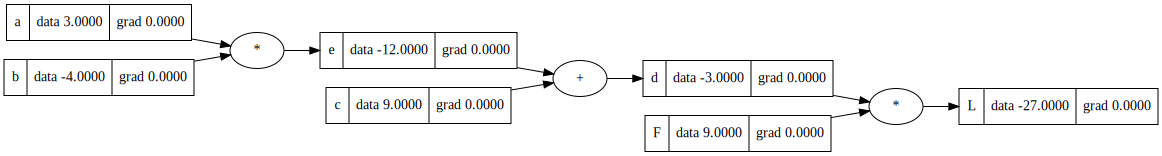

In [390]:
draw_dot(L)

In [391]:
#Manually Assigning Grad Values:
d.grad=9
F.grad=-3
e.grad=9
L.grad=1
b.grad=27
a.grad=-36

In [392]:
#Dummy Function to verify Grad
def lol():

  h = 0.001
  a = Value(3.0, label='a')
  b = Value(-4.0, label='b')
  c = Value(9.0, label ='c')
  e = a*b ; e.label='e'
  d = e + c ; d.label='d'
  F = Value(9) ; F.label='F'
  L = d*F; L.label='L'
  L1 = L.data
#------------------------------------------------
  a = Value(3.0, label='a')
  b = Value(-4.0, label='b')
  a.data+=h
  c = Value(9.0, label ='c')
  e = a*b ; e.label='e'

  d = e + c ; d.label='d'
  F = Value(9) ; F.label='F'

  L = d*F; L.label='L'
  L2 = L.data

  print((L2-L1)/h)
lol()

-35.99999999999426


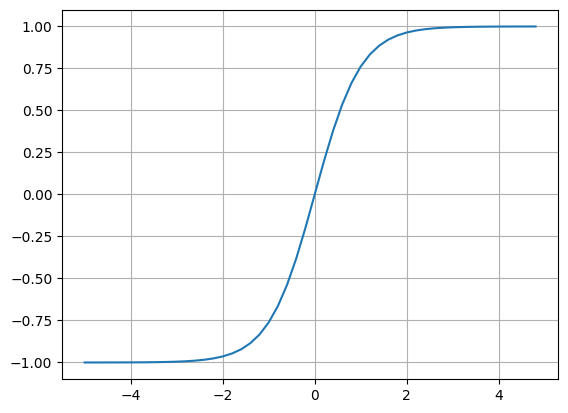

In [393]:
#tanh Graph
plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5, 5, 0.2))); plt.grid();

In [394]:
#Single Neuron Forward Pass

#input Variables
x1 = Value(2, label='x1')
x2 = Value(0, label='x2')

#wieghts
w1 = Value(-3, label='w1')
w2 = Value(1, label='w2')

#bias variable
b = Value(6.8813735870195432, label='b')
x1w1 = x1 * w1 ; x1w1.label='x1w1'
x2w2 = x2 * w2 ; x2w2.label='x2w2'

x1w1x2w2 = x1w1 + x2w2 ; x1w1x2w2.label='x1w1+x2w2'
n = x1w1x2w2 + b ; n.label='n'
o = n.tanh() ; o.label='o'

In [395]:
#Manual Calc. to verify Grad

#input Variables
x1 = Value(2, label='x1')
x2 = Value(0, label='x2')

#wieghts
w1 = Value(-3, label='w1')
w2 = Value(1, label='w2')

#bias variable
b = Value(6.8813735870195432, label='b')
x1w1 = x1 * w1 ; x1w1.label='x1w1'
x2w2 = x2 * w2 ; x2w2.label='x2w2'

x1w1x2w2 = x1w1 + x2w2 ; x1w1x2w2.label='x1w1+x2w2'
n = x1w1x2w2 + b ; n.label='n'
o = n.tanh() ; o.label='o'
o1 = o.data


#---------------------------------------------------------

h=0.000001
#input Variables
x1 = Value(2, label='x1')
x2 = Value(0, label='x2')

#wieghts
w1 = Value(-3, label='w1')
w2 = Value(1, label='w2')

#bias variable
b = Value(6.8813735870195432, label='b')
x1w1 = x1 * w1 ; x1w1.label='x1w1'
x2w2 = x2 * w2 ; x2w2.label='x2w2'

x1w1x2w2 = x1w1 + x2w2 ; x1w1x2w2.label='x1w1+x2w2'
n = x1w1x2w2 + b ; n.label='n'
n.data+=h
o = n.tanh() ; o.label='o'
o2 = o.data
print((o2-o1)/h)

0.49999964646385564


In [396]:
o.grad=1

In [397]:
o.backward()

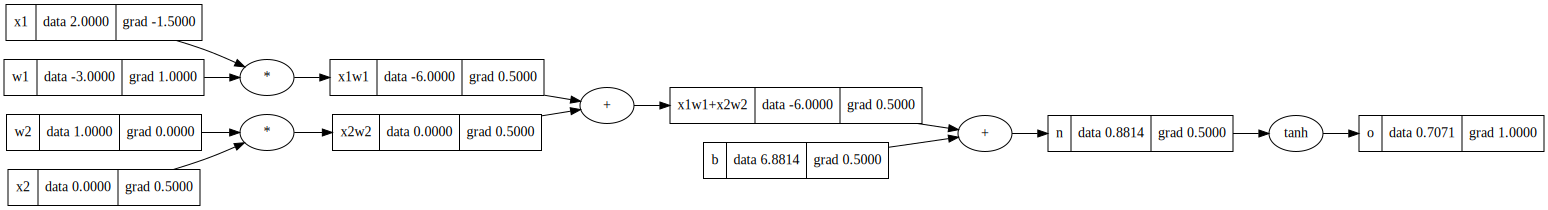

In [398]:
draw_dot(o)

In [399]:
#TOPO-SORT:
# topo=[]
# visited = set()
# def build_topo(v):
#   if v not in visited:
#     visited.add(v)
#     for child in v._prev:
#       build_topo(child)
#     topo.append(v)
# build_topo(o)
# topo

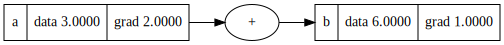

In [400]:
#Verifying grad Values on "a+a"
a = Value(3, label='a')
b = a + a; b.label='b'
b.backward()
draw_dot(b)

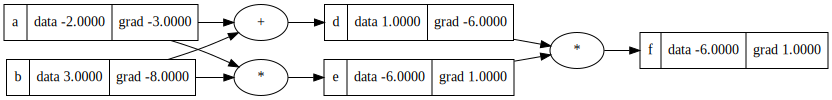

In [401]:
#Verifying grad Values for common input Variables used in more than one expressions
a = Value(-2, label='a')
b = Value(3, label='b')
d = a + b; d.label='d'
e = a * b; e.label='e'
f = d * e; f.label='f'
f.backward()
draw_dot(f)

In [402]:
a = Value(-2, label='a')
b = Value(3, label='b')
a - b

Value(data=-5)

In [403]:
import torch

In [404]:
#Neuron Pass using Torch-(Tensor)
x1 = torch.Tensor([2.0]).double()                   ;x1.requires_grad=True
x2 = torch.Tensor([0.0]).double()                   ;x2.requires_grad=True
w1 = torch.Tensor([-3.0]).double()                  ;w1.requires_grad=True
w2 = torch.Tensor([1.0]).double()                   ;w2.requires_grad=True
x1w1x2w2 = x1*w1 + x2*w2
b = torch.Tensor([6.8813735870195432]).double()     ; b.requires_grad=True
n = x1w1x2w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()
print("-----------")
print('x1', x1.grad.item())
print('w1', w1.grad.item())
print('x2', x2.grad.item())
print('w2', w2.grad.item())

0.7071066904050358
-----------
x1 -1.5000003851533106
w1 1.0000002567688737
x2 0.5000001283844369
w2 0.0


In [405]:
#Neuron
import random # Import random for uniform

class Neuron:
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1, 1)) for i in range (nin)]
    self.b = Value(random.uniform(-1, 1))


  def __call__(self, x):
    act = sum((w1*x1 for w1, x1 in zip(self.w, x)), self.b)
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]

class Layer:
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for i in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class NLP:
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.Layer = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.Layer:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.Layer for p in layer.parameters()]



In [406]:
x = [2, 3, -1]
n = NLP(3, [4, 4, 1])
n(x)

Value(data=-0.5236661367959794)

In [407]:
len(n.parameters())

41

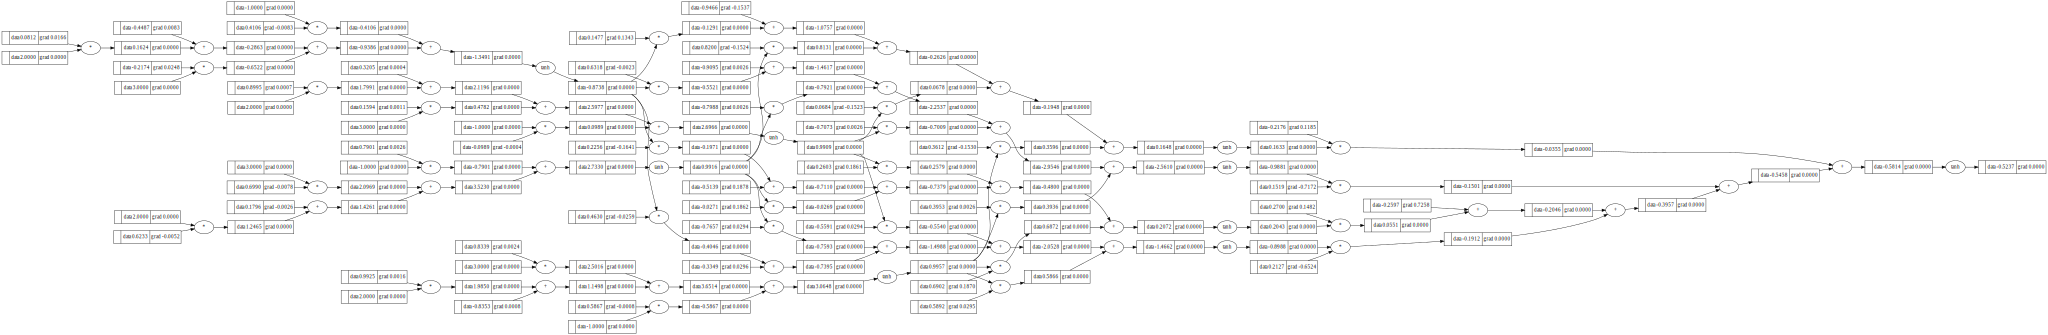

In [408]:
n(x).backward()
draw_dot(n(x))

In [409]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0] #desired Prediction

In [410]:
# The training loop
for k in range(100):

    # Forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

    # (*must do before backward pass*) Update parameters-----
    for p in n.parameters():
      p.grad = 0.0

    #backward pass
    loss.backward()

    # Update parameters
    for p in n.parameters():
        p.data += -0.01 * p.grad # Using a learning rate of 0.01

    print(f"Iteration {k}: Loss = {loss.data}")

Iteration 0: Loss = 5.14817873281322
Iteration 1: Loss = 4.8526442546716995
Iteration 2: Loss = 4.581778460358236
Iteration 3: Loss = 4.352382570341415
Iteration 4: Loss = 4.171421910229818
Iteration 5: Loss = 4.035402694620556
Iteration 6: Loss = 3.9346195192848867
Iteration 7: Loss = 3.8582075178172945
Iteration 8: Loss = 3.797112552869475
Iteration 9: Loss = 3.744868031615715
Iteration 10: Loss = 3.697236118176403
Iteration 11: Loss = 3.651559491961873
Iteration 12: Loss = 3.6061954942150805
Iteration 13: Loss = 3.5601182687240103
Iteration 14: Loss = 3.5126668411924302
Iteration 15: Loss = 3.4633953301930953
Iteration 16: Loss = 3.411988060217902
Iteration 17: Loss = 3.3582138126140944
Iteration 18: Loss = 3.30190285730861
Iteration 19: Loss = 3.2429367705875944
Iteration 20: Loss = 3.181244996304208
Iteration 21: Loss = 3.116804468531655
Iteration 22: Loss = 3.0496400218490685
Iteration 23: Loss = 2.9798241968105112
Iteration 24: Loss = 2.907475658265058
Iteration 25: Loss = 2.832

In [411]:
ypred

[Value(data=0.758840056299213),
 Value(data=-0.828546163686673),
 Value(data=-0.75941636688315),
 Value(data=0.8654525335189024)]